# Masalah Kearusakan Bearing (Klaher)

Diberikan data kerusakan Bearing sudatu uji kualitas produk Bearing dari devisi QC seperti pada Gambar berikut:
![image-2.png](attachment:image-2.png)

Warna biru: merepresentasikan data bearing yang Baik (OK) sedangan  warna merah merepresentasikan Rusak (tidak OK). Perbanding jumlah sample data Baik vs Rusak sebanyak: 1864 vs 136. Data kerusakan simpan dalam file data dengan format ".mat" yang dapat diunduh dilink https://drive.google.com/file/d/1UftoS3q351WhdI0oHMLxi58_C0KiFwqE/view?usp=sharing. Data tersimpan dengan struktur array pertama adalah target yang bernilai 1, 2, dan 3 yang merepresentasikan *OK, OverLoad, Bad*.
Rancangan suatu solusi berbasis ANN yang dapat menyelesaikan permasalahan tersebut. 

Untuk menyelesaikan permasalahan ini diperlukan beberapa langkah yaitu:
1. Load data dan simpan dalam array
2. Plot data untuk memastikan apakah data yang diload telah sesuai dengan Gambar yang diberikan 
3. Gunakan PCA untuk melakukan reduksi dimensional dari data input. 
4. Rancang ANN:
    + Data preparation
    + Design MLP
    + Training dan evaluasi
5. Kesimpulan     

## 1. Load data dan simpan dalam array
Untuk mengload data dengan format ".mat" dapat dilakukan dengan fungsi dibawah ini. Fungsi ini bersumber dari link: #https://gist.github.com/black-puppydog/e74b86319d25dc307a1dc3587ade6469. Dengan memanfaatkan fungsi ini maka data dapat di load dengan memanggil fungsi "load_matfile(namafile):"

In [12]:
import numpy as np
import scipy.io as scio

def parse_mat(o):
    # this seems to happen for lists (1D cell arrays usually)
    if o.__class__ == np.ndarray and o.dtype == np.object and len(o.shape) > 0:
        assert len(o.shape) == 1, "didn't see this coming"
        return [parse_mat(entry) for entry in o]
    
    # this would be a matlab struct
    if o.__class__ == scio.matlab.mio5_params.mat_struct:
        return {fn: parse_mat(getattr(o, fn)) for fn in o._fieldnames}
    
    # this means this should either be a regular numeric matrix
    # or a scalar
    return o

def load_matfile(fname):
    mat = scio.loadmat(fname, struct_as_record=False, squeeze_me=True)
    keys = [k for k in mat.keys() if not k.startswith('_')]
    if len(keys) == 1:
        return parse_mat(mat[keys[0]])
    else:
        return [parse_mat(mat[k]) for k in keys]
dt=load_matfile('data.mat')
print('data=',dt)

data= [array([1, 1, 1, ..., 2, 1, 1], dtype=uint8), array([[-0.04901449, -0.05344559, -0.0450396 , ...,  1.23450677,
         1.24494634,  1.24289793],
       [-0.05630339, -0.0442738 , -0.03232197, ...,  1.28481662,
         1.28348885,  1.27425343],
       [-0.05361775, -0.04876542, -0.03409616, ...,  1.23702617,
         1.23956674,  1.23261425],
       ...,
       [-0.02946778, -0.03200098, -0.0475355 , ...,  1.11744336,
         1.11268318,  1.12247897],
       [-0.04460944, -0.04840634, -0.03409792, ...,  1.37600978,
         1.38447876,  1.3804856 ],
       [-0.04954877, -0.03705591, -0.02783408, ...,  1.38655055,
         1.38152458,  1.36579942]]), ['1=OK', '2=Overload', '3=Crack']]


Setelah diload data dipisahkan menjadi *target, data, dan label*, dengan cara:

In [13]:
target=np.array(dt[0])
data=np.array(dt[1])
label=np.array(dt[2])

print ('ukuran target:',target.shape)
print ('ukuran data:',data.shape)
print ('ukuran label:',label.shape)

ukuran target: (2000,)
ukuran data: (2000, 100)
ukuran label: (3,)


## 2. View data
Pisahkan data dengan label 1=OK dan lainya tidak OK. Kemudian plot hasilnya. 

In [14]:
idx1 = np.where(target ==1)
idx2 = np.where(target >1)

y1=data[idx1,:]
y2=data[idx2,:]
print ('ukuran y1:',y1.shape)
print ('ukuran y2:',y2.shape)

ukuran y1: (1, 1864, 100)
ukuran y2: (1, 136, 100)


Proses selanjutnya adalah plotting data yang berasosiasi OK dan Tidak OK:

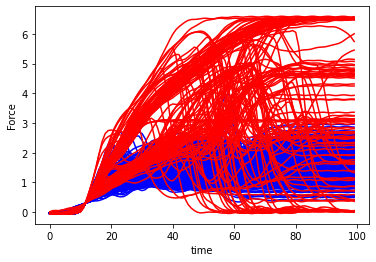

In [15]:
#Plot data OK
x1 = np.arange(0.0, 100, 1)
y1=y1.reshape(1864, 100)
import matplotlib.pyplot as plt
for i in range(1864):
    plt.plot(x1,y1[i,:],'b')

#Plot data Not OK 
y1=y2.reshape(136, 100)
for i in range(136):
    plt.plot(x1,y1[i,:],'r')
plt.ylabel('Force')
plt.xlabel('time')
plt.show()

## 3. Pengurangan Dimensi

In [16]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# Standardizing the features
data = StandardScaler().fit_transform(data)

pca = PCA(n_components=2)
fPca = pca.fit_transform(data)

In [17]:
print(fPca.shape)
y1=fPca[idx1,:]
y2=fPca[idx2,:]
print(y1.shape)
print(y2.shape)

(2000, 2)
(1, 1864, 2)
(1, 136, 2)


Plot hasil PCA

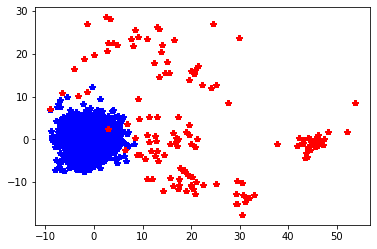

In [18]:
y1=fPca[idx1,:]
y2=fPca[idx2,:]
y1=y1.reshape(1864,2)

for i in range(1864):
    plt.plot(y1[:,0],y1[:,1],'b*')
    
y1=y2.reshape(136, 2)
for i in range(136):
    plt.plot(y1[:,0],y1[:,1],'r*')
plt.show()

## 4. Rancang ANN
1. Penyiapan data

In [19]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

def generateClassificationReport(y_test,y_pred):
    print(classification_report(y_test,y_pred))
    print(confusion_matrix(y_test,y_pred))    
    print('accuracy is ',accuracy_score(y_test,y_pred))

ID=np.zeros(2000)
ID[idx2]=1;

#Define train and test set
X_train,X_test,y_train,y_test = train_test_split(fPca,ID,test_size=0.2, random_state=0)
print ('ukuran X_train:',X_train.shape)
print ('ukuran X_test:',X_test.shape)

ukuran X_train: (1600, 2)
ukuran X_test: (400, 2)


2. Create MLP model

In [20]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
#Create ANN
from sklearn.neural_network import MLPClassifier
mlp = MLPClassifier(hidden_layer_sizes=(6,4),max_iter=500)

3. Training dan Evaluasi

In [21]:
#Training
mlp.fit(X_train,y_train)

#Evaluation
y_pred = mlp.predict(X_test)

#Show the performance 
generateClassificationReport(y_test,y_pred)

              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00       375
         1.0       1.00      0.96      0.98        25

    accuracy                           1.00       400
   macro avg       1.00      0.98      0.99       400
weighted avg       1.00      1.00      1.00       400

[[375   0]
 [  1  24]]
accuracy is  0.9975


In [22]:
#Define train and test set
X_train,X_test,y_train,y_test = train_test_split(fPca,ID,test_size=0.3, random_state=0)
print ('ukuran X_train:',X_train.shape)
print ('ukuran X_test:',X_test.shape)

mlp = MLPClassifier(hidden_layer_sizes=(4,3),max_iter=500)

#Training
mlp.fit(X_train,y_train)

#Evaluation
y_pred = mlp.predict(X_test)

#Show the performance 
generateClassificationReport(y_test,y_pred)


ukuran X_train: (1400, 2)
ukuran X_test: (600, 2)
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00       568
         1.0       1.00      0.97      0.98        32

    accuracy                           1.00       600
   macro avg       1.00      0.98      0.99       600
weighted avg       1.00      1.00      1.00       600

[[568   0]
 [  1  31]]
accuracy is  0.9983333333333333


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


3. Create another MLP model

In [23]:
#Create ANN
from sklearn.neural_network import MLPClassifier
mlp_new = MLPClassifier(hidden_layer_sizes=(12,8),max_iter=1000)

4. Training dan Evaluasi

In [24]:
#Training
mlp_new.fit(X_train,y_train)

#Evaluation
y_pred = mlp_new.predict(X_test)

#Show the performance 
generateClassificationReport(y_test,y_pred)

              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00       568
         1.0       1.00      0.97      0.98        32

    accuracy                           1.00       600
   macro avg       1.00      0.98      0.99       600
weighted avg       1.00      1.00      1.00       600

[[568   0]
 [  1  31]]
accuracy is  0.9983333333333333


In [25]:
#Define train and test set
X_train,X_test,y_train,y_test = train_test_split(fPca,ID,test_size=0.2, random_state=0)
print ('ukuran X_train:',X_train.shape)
print ('ukuran X_test:',X_test.shape)

mlp = MLPClassifier(hidden_layer_sizes=(8,6),max_iter=1000)

#Training
mlp.fit(X_train,y_train)

#Evaluation
y_pred = mlp.predict(X_test)

#Show the performance 
generateClassificationReport(y_test,y_pred)

ukuran X_train: (1600, 2)
ukuran X_test: (400, 2)
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00       375
         1.0       1.00      0.96      0.98        25

    accuracy                           1.00       400
   macro avg       1.00      0.98      0.99       400
weighted avg       1.00      1.00      1.00       400

[[375   0]
 [  1  24]]
accuracy is  0.9975
